In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

import rpy2 as rp
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import pyreadr

import os
import time
import h5py
# import mmdet
import scanpy
# import ssam
import pickle
import random
# import pyarrow
import dgl
import ast

import anndata as ad
import scanpy as sc
import scipy.sparse as sp
from sklearn import metrics
import multiprocessing as mp
from GraphST import GraphST
from h5py import File

from tqdm import tqdm

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, matthews_corrcoef, mean_squared_error

# from captum.attr import IntegratedGradients
# from captum.attr import LayerConductance
# from captum.attr import NeuronConductance

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

# import torch_geometric

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils

from skimage import io
from skimage import img_as_float
from scipy import ndimage

# from ssam.utils import corr, calc_ctmap, calc_corrmap, flood_fill, calc_kde
from scipy.spatial.distance import cdist

from collections import OrderedDict

from packaging import version
import subprocess

2024-10-16 15:22:32.622515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 15:22:32.622549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 15:22:32.623255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 15:22:33.191185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from matplotlib.image import imread
import json
from pathlib import Path, PurePath

def put_image(adata, path, library_id, arr_col=True):
    source_image_path = path
    adata.uns["spatial"] = dict()
    # from h5py import File
    
    # with File(path / count_file, mode="r") as f:
    #     attrs = dict(f.attrs)
    # if library_id is None:
    #     library_id = str(attrs.pop("library_ids")[0], "utf-8")
    adata.uns["spatial"][library_id] = dict()
    tissue_positions_file = path + "/spatial/tissue_positions_list.csv"
    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=path + "/spatial/scalefactors_json.json",
        hires_image=path + "/spatial/tissue_hires_image.png",
        lowres_image=path + "/spatial/tissue_lowres_image.png",
    )
    # check if files exists, continue if images are missing
    # for f in files.values():
    #     if not f.exists():
    #         if any(x in str(f) for x in ["hires_image", "lowres_image"]):
    #             logg.warning(
    #                 f"You seem to be missing an image file.\n"
    #                 f"Could not find '{f}'."
    #             )
    #         else:
    #             raise OSError(f"Could not find '{f}'")
    
    adata.uns["spatial"][library_id]["images"] = dict()
    for res in ["hires", "lowres"]:
        try:
            adata.uns["spatial"][library_id]["images"][res] = imread(
                str(files[f"{res}_image"])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")
    
    # read json scalefactors
    adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
        Path(files["scalefactors_json_file"]).read_text()
    )
    
    # adata.uns["spatial"][library_id]["metadata"] = {
    #     k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    #     for k in ("chemistry_description", "software_version")
    #     if k in attrs
    # }
    
    # read coordinates
    positions = pd.read_csv(
        files["tissue_positions_file"],
        header= None,
        index_col=0,
    )
    positions.columns = [
        "in_tissue",
        "array_row",
        "array_col",
        "pxl_col_in_fullres",
        "pxl_row_in_fullres",
    ]
    if arr_col:
        adata.obs = adata.obs.join(positions, how="left")
        
        adata.obsm["spatial"] = adata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
        adata.obs.drop(
            columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
            inplace=True,
        )
    
    # put image path in uns
    # if source_image_path is not None:
    #     # get an absolute path
    #     source_image_path = str(Path(source_image_path).resolve())
    #     adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
    #         source_image_path
    #     )

    return adata

In [3]:
import sys
sys.path

['/workspace/volume/spatial_integration/GNN_based/combined/New',
 '/opt/conda/lib/python310.zip',
 '/opt/conda/lib/python3.10',
 '/opt/conda/lib/python3.10/lib-dynload',
 '',
 '/root/.local/lib/python3.10/site-packages',
 '/root/.local/lib/python3.10/site-packages/GraphST-1.1.1-py3.10.egg',
 '/opt/conda/lib/python3.10/site-packages/certifi-2024.2.2-py3.10.egg',
 '/opt/conda/lib/python3.10/site-packages',
 '/opt/conda/lib/python3.10/site-packages/STAGATE-1.0.1-py3.10.egg',
 '/opt/conda/lib/python3.10/site-packages/STAGATE_pyG-1.0.0-py3.10.egg',
 '/opt/conda/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg']

In [4]:
temp_path = '/workspace/volume/spatial_integration/GNN_based/combined/'
if temp_path not in sys.path:
    sys.path.append(temp_path)
sys.path

['/workspace/volume/spatial_integration/GNN_based/combined/New',
 '/opt/conda/lib/python310.zip',
 '/opt/conda/lib/python3.10',
 '/opt/conda/lib/python3.10/lib-dynload',
 '',
 '/root/.local/lib/python3.10/site-packages',
 '/root/.local/lib/python3.10/site-packages/GraphST-1.1.1-py3.10.egg',
 '/opt/conda/lib/python3.10/site-packages/certifi-2024.2.2-py3.10.egg',
 '/opt/conda/lib/python3.10/site-packages',
 '/opt/conda/lib/python3.10/site-packages/STAGATE-1.0.1-py3.10.egg',
 '/opt/conda/lib/python3.10/site-packages/STAGATE_pyG-1.0.0-py3.10.egg',
 '/opt/conda/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg',
 '/workspace/volume/spatial_integration/GNN_based/combined/']

In [5]:
from GraphST_1 import GraphST as GS1

In [6]:
import scvi

/opt/conda/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/opt/conda/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [7]:
import harmonypy as hm

In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

<h1>Take Matrix

In [9]:
os.getcwd()
directory = '/workspace/volume/spatial_integration/GNN_based/combined/'
dataset = '151507'
dat = "feather"
GNs = "5thset_GN1000_GS1"
data_folder = "/workspace/volume/spatial_integration/dataset/GraphST/DLPFC/samples/"+str(dataset)
data_dir = "/workspace/volume/spatial_integration/dataset/GraphST/DLPFC/samples/"
new_folder = "/workspace/volume/spatial_integration/GNN_based/combined/processed_data/"

In [10]:
# read from rds
raw_151507 = pyreadr.read_r(directory + 'processed_data/df_rawcount_507.rds')
raw_151508 = pyreadr.read_r(directory + 'processed_data/df_rawcount_508.rds')
raw_151509 = pyreadr.read_r(directory + 'processed_data/df_rawcount_509.rds')
# raw_151676 = pyreadr.read_r(directory + 'processed_data/df_rawcount_676.rds')

# mat_151507 = pyreadr.read_r(directory + 'processed_data/df_logcount_507.rds')
# mat_151508 = pyreadr.read_r(directory + 'processed_data/df_logcount_508.rds')
# mat_151509 = pyreadr.read_r(directory + 'processed_data/df_logcount_509.rds')
# mat_151676 = pyreadr.read_r(directory + 'processed_data/df_logcount_676.rds')

spat_507 = np.load(directory + 'processed_data/4thset_encoded_151507_unfil.npy')
spat_508 = np.load(directory + 'processed_data/4thset_encoded_151508_unfil.npy') 
spat_509 = np.load(directory + 'processed_data/4thset_encoded_151509_unfil.npy') 
# spat_676 = np.load(directory + 'processed_data/5thset_encoded_151676_unfil.npy') 

In [11]:
# raw_151507[None].shape

In [12]:
import scanpy as sc
import anndata as ad

In [13]:
# adata = ad.AnnData(raw_151507[None].T)
# adata

In [14]:
adata1 = sc.read_visium(data_folder, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata1

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [14]:
adata2 = sc.read_visium(data_dir+'151508', count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata2

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [15]:
adata3 = sc.read_visium(data_dir+'151509', count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata3

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4789 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [16]:
if adata1.obs.index.duplicated().any():
    print("Duplicate cell labels in adata1:", adata1.obs.index[adata1.obs.index.duplicated()])

if adata2.obs.index.duplicated().any():
    print("Duplicate cell labels in adata2:", adata2.obs.index[adata2.obs.index.duplicated()])

In [17]:
adata1.obs = adata1.obs.loc[~adata1.obs.index.duplicated()].copy()  # Removing duplicates
adata2.obs = adata2.obs.loc[~adata2.obs.index.duplicated()].copy()

In [18]:
adata1.obs_names_make_unique()
adata2.obs_names_make_unique()
adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata3.var_names_make_unique()

In [19]:
adata_concat1 = ad.concat([adata1, adata2], axis=0)
adata_concat1

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 8610 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    obsm: 'spatial'

In [20]:
adata_concat = ad.concat([adata_concat1,adata3], axis=0)
adata_concat

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 13399 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    obsm: 'spatial'

In [21]:
adata_concat1.obs['batch_key'] = ['batch1'] * adata1.shape[0] + ['batch2'] * adata2.shape[0] 
adata_concat1

AnnData object with n_obs × n_vars = 8610 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key'
    obsm: 'spatial'

In [22]:
adata_concat.obs['batch_key'] = ['batch1'] * adata1.shape[0] + ['batch2'] * adata2.shape[0] + ['batch3'] * adata3.shape[0]
adata_concat

AnnData object with n_obs × n_vars = 13399 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key'
    obsm: 'spatial'

In [23]:
adata_concat1.obs['batch_key'].value_counts()

batch_key
batch2    4384
batch1    4226
Name: count, dtype: int64

In [24]:
adata_concat.obs['batch_key'].value_counts()

batch_key
batch3    4789
batch2    4384
batch1    4226
Name: count, dtype: int64

In [25]:
adata_concat.obs['batch_key'].value_counts()

batch_key
batch3    4789
batch2    4384
batch1    4226
Name: count, dtype: int64

In [26]:
sc.pp.highly_variable_genes(adata_concat, flavor="seurat_v3", n_top_genes=3000, batch_key = 'batch_key')
sc.pp.normalize_total(adata_concat, target_sum=1e4)
sc.pp.log1p(adata_concat)
sc.pp.scale(adata_concat, zero_center=False, max_value=10)

In [27]:
model = GraphST.GraphST(adata_concat, device=device)
adata_concat = model.train()

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Begin to train ST data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:06<00:00,  9.08it/s]


Optimization finished for ST data!


In [28]:
adata_concat

AnnData object with n_obs × n_vars = 13399 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [29]:
adata1

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [30]:
# sc.pp.highly_variable_genes(adata_true, n_top_genes=2000, flavor='seurat_v3', batch_key=batch_key)

In [31]:
adata_507 = adata_concat[adata_concat.obs['batch_key']=='batch1', :]
adata_507

View of AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [32]:
adata_508 = adata_concat[adata_concat.obs['batch_key']=='batch2', :]
adata_508

View of AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [34]:
adata_507 = put_image(adata_507, data_folder, dataset, arr_col=False)

/tmp/ipykernel_2768674/1313071846.py:7: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["spatial"] = dict()


In [35]:
adata_508 = put_image(adata_508, data_dir + '151508', '151508', arr_col=False)

/tmp/ipykernel_2768674/1313071846.py:7: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["spatial"] = dict()


------------------------

In [35]:
dataset = '151507'
if dataset == '151507':
    # beer_1 507
    layer_labels = pd.read_csv(directory + 'layer_507_pos.csv')
elif dataset == '151508':
    # beer_2 508
    layer_labels = pd.read_csv(directory + 'layer_508_pos.csv')
elif dataset == '151509':
    # beer_3 509
    layer_labels = pd.read_csv(directory + 'layer_509_pos.csv')
elif dataset == '151676':
    # beer_3 509
    layer_labels = pd.read_csv(directory + 'layer_676_pos.csv')
# layer_labels = pd.read_csv('layer_508_pos.csv')
# layer_labels change into 507,508,or 509 accordingly

In [27]:
layer_labels_507 = pd.read_csv(directory + 'layer_507_pos.csv')
layer_labels_508 = pd.read_csv(directory + 'layer_508_pos.csv')

In [47]:
adata_507.obs['ground_truth']= layer_labels_507['layer_guess'].values

In [48]:
adata_508.obs['ground_truth']= layer_labels_508['layer_guess'].values

In [49]:
os.environ['R_HOME'] = '/usr/lib/R'

In [39]:
radius = 50

tool = 'mclust' # mclust, leiden, and louvain
if dataset =='151672':
    n_clusters = 5
else:
    n_clusters = 7
# clustering
from GraphST.utils import clustering

In [51]:
n_clusters

7

In [41]:
if tool == 'mclust':
   clustering(adata_507, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata_507, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%


In [39]:
adata_507

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key', 'ground_truth', 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'spatial'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'

/tmp/ipykernel_2767429/4140427938.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_507.uns['ARI']=ARI


Dataset: 151507
ARI:  0.3810102903077821


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


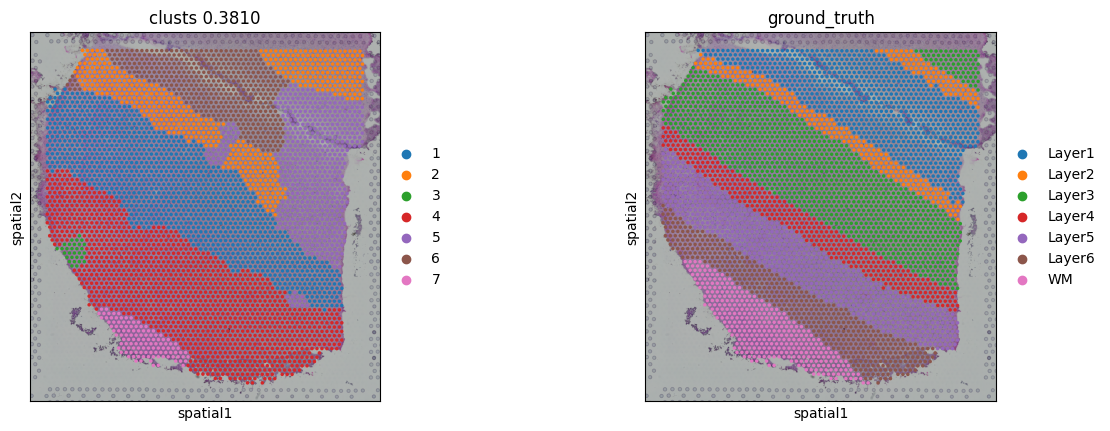

In [42]:
adata_507 = adata_507[~pd.isnull(adata_507.obs['ground_truth'])]

ARI = metrics.adjusted_rand_score(adata_507.obs['domain'], adata_507.obs['ground_truth'])
adata_507.uns['ARI']=ARI

print('Dataset:', dataset)
print('ARI: ', ARI)
                                  
sc.pl.spatial(adata_507, img_key='hires',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
              save=None)                                

In [51]:
sc.pp.neighbors(adata_507)
sc.tl.umap(adata_507, use_rep=)
adata_507

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key', 'ground_truth', 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'spatial', 'ARI', 'domain_colors', 'ground_truth_colors', 'neighbors', 'umap'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

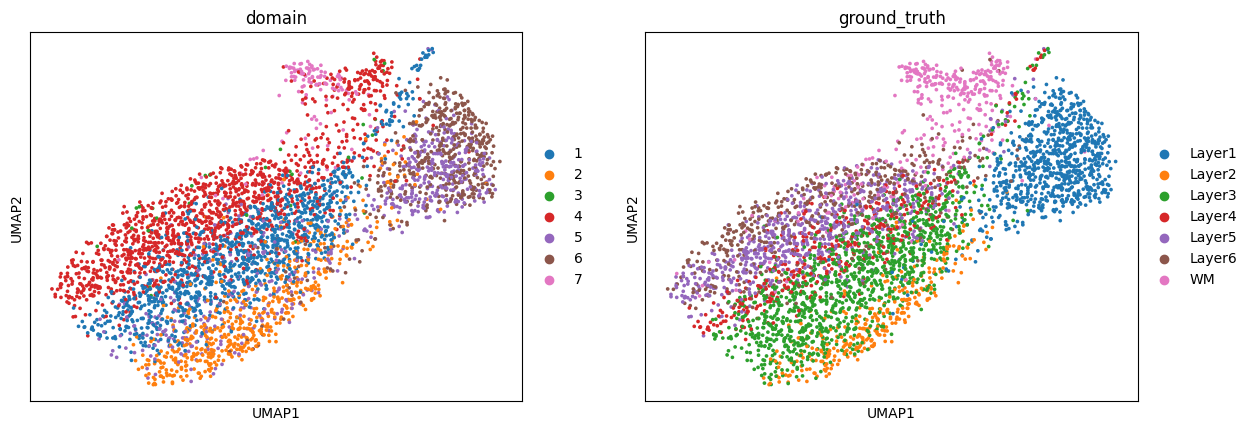

In [53]:
sc.pl.umap(adata_507, color=['domain','ground_truth'])

In [36]:
import harmonypy as hm

In [44]:
sc.pp.neighbors(adata_508, use_rep='emb')
sc.tl.umap(adata_508)
adata_508

AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'spatial', 'neighbors', 'umap'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'X_umap'
    obsp: 'distances', 'connectivities'

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

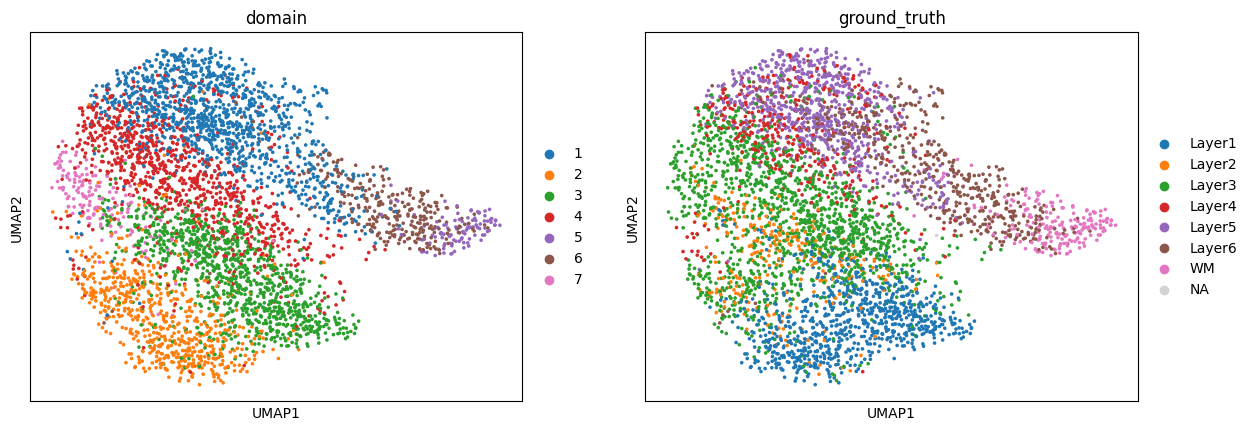

In [54]:
sc.pl.umap(adata_508, color=['domain','ground_truth'])

/tmp/ipykernel_2767039/308080688.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_673.uns['ARI']=ARI


Dataset: 151673
ARI:  0.5166048115708006


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


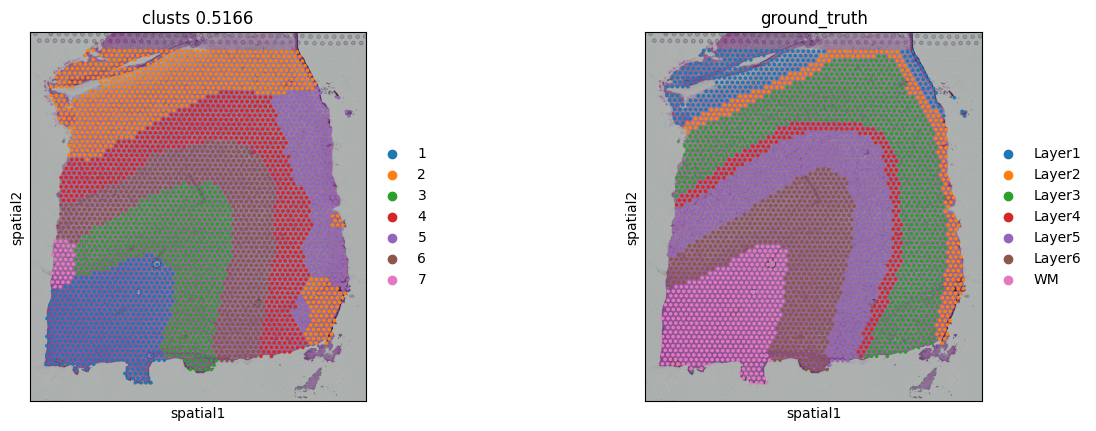

In [45]:
adata_507 = adata_507[~pd.isnull(adata_507.obs['ground_truth'])]

ARI = metrics.adjusted_rand_score(adata_507.obs['domain'], adata_507.obs['ground_truth'])
adata_507.uns['ARI']=ARI

print('Dataset:', dataset)
print('ARI: ', ARI)
                                  
sc.pl.spatial(adata_507, img_key='hires',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
              save=None)                                

In [52]:
if tool == 'mclust':
   clustering(adata_508, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata_508, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [53]:
adata_508

AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_key', 'ground_truth', 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'spatial', 'neighbors', 'umap'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'X_umap', 'emb_pca'
    obsp: 'distances', 'connectivities'

/tmp/ipykernel_2767429/3615694000.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_508.uns['ARI']=ARI


Dataset: 151507
ARI:  0.40697644637660524


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


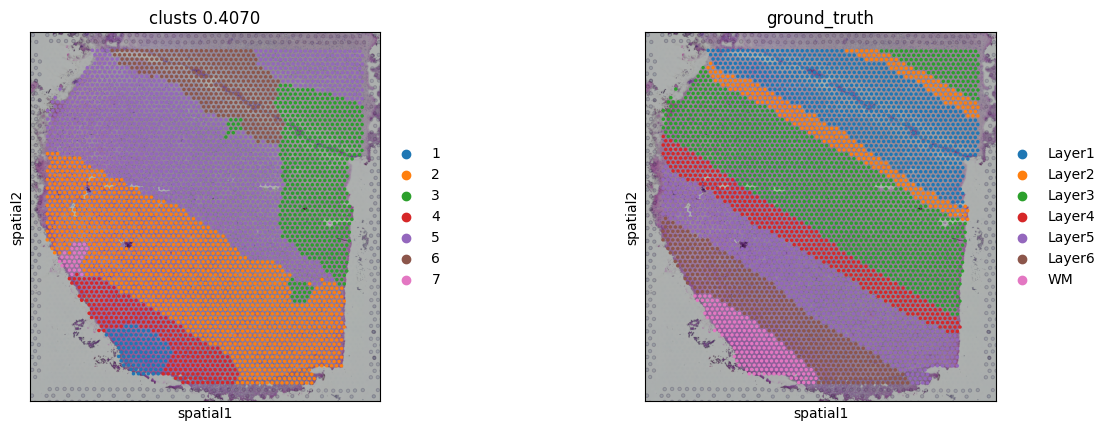

In [47]:
adata_508 = adata_508[~pd.isnull(adata_508.obs['ground_truth'])]

ARI = metrics.adjusted_rand_score(adata_508.obs['domain'], adata_508.obs['ground_truth'])
adata_508.uns['ARI']=ARI

print('Dataset:', dataset)
print('ARI: ', ARI)
                                  
sc.pl.spatial(adata_508, img_key='hires',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
              save=None)                                

/tmp/ipykernel_2767039/3974747043.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_674.uns['ARI']=ARI


Dataset: 151673
ARI:  0.571128516719447


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


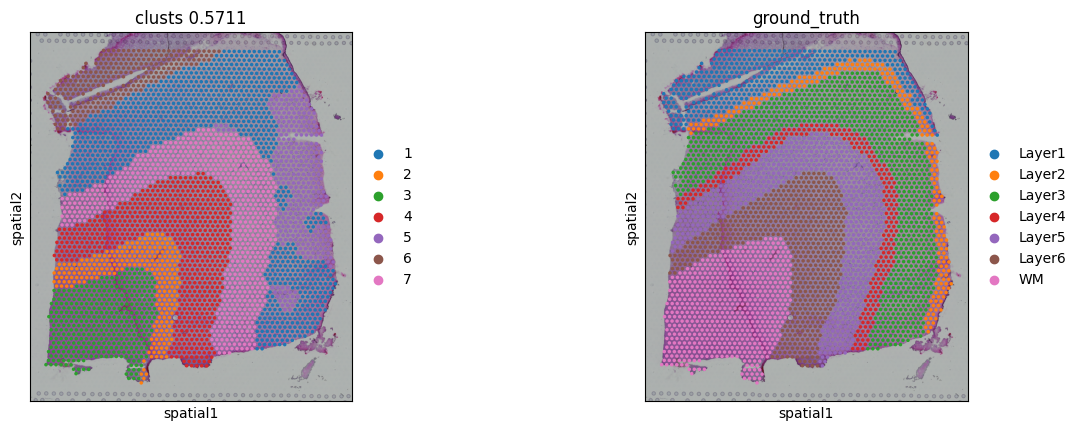

In [48]:
adata_508 = adata_508[~pd.isnull(adata_508.obs['ground_truth'])]

ARI = metrics.adjusted_rand_score(adata_508.obs['domain'], adata_508.obs['ground_truth'])
adata_508.uns['ARI']=ARI

print('Dataset:', dataset)
print('ARI: ', ARI)
                                  
sc.pl.spatial(adata_508, img_key='hires',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
              save=None)                                

<h2> Spat Experiment </h2>

In [15]:
# dict to dataframe
df_151507 = raw_151507[None]
df_151508 = raw_151508[None]
df_151509 = raw_151509[None]
# df_151676 = mat_151676[None]
combined_507_508 = pd.concat([df_151507,df_151508],axis=1)
combined_all = pd.concat([combined_507_508,df_151509],axis=1)
# combined_all = pd.concat([combined_507_508_509,df_151676],axis=1)

In [16]:
df_spat507 = pd.DataFrame(spat_507.reshape((spat_507.shape[0],spat_507.shape[-1])))
df_spat508 = pd.DataFrame(spat_508.reshape((spat_508.shape[0],spat_508.shape[-1])))
df_spat509 = pd.DataFrame(spat_509.reshape((spat_509.shape[0],spat_509.shape[-1])))
# df_spat676 = pd.DataFrame(spat_676.reshape((spat_676.shape[0],spat_676.shape[-1])))

In [17]:
df_spat507

0         1         2         3         4         5         6     \
0      0.504408  0.499566  0.502207  0.502553  0.498529  0.501547  0.500444   
1      0.504408  0.499566  0.502207  0.502553  0.498529  0.501547  0.500444   
2      0.504408  0.499566  0.502207  0.502553  0.498529  0.501547  0.500444   
3      0.504397  0.499574  0.502204  0.502538  0.498508  0.501531  0.500424   
4      0.504408  0.499566  0.502207  0.502553  0.498529  0.501547  0.500444   
...         ...       ...       ...       ...       ...       ...       ...   
33533  0.504408  0.499566  0.502207  0.502553  0.498529  0.501547  0.500444   
33534  0.504408  0.499566  0.502207  0.502553  0.498529  0.501547  0.500444   
33535  0.504406  0.499571  0.502208  0.502551  0.498523  0.501543  0.500437   
33536  0.504408  0.499566  0.502207  0.502553  0.498529  0.501547  0.500444   
33537  0.504408  0.499566  0.502207  0.502553  0.498529  0.501547  0.500444   

           7         8         9     ...      4216      4217      4218  \
0      0.500442  0.499396  0.501924  ...  0.506481  0.503693  0.502144   
1      0.500442  0.499396  0.501924  ...  0.506481  0.503693  0.502144   
2      0.500442  0.499396  0.501924  ...  0.506481  0.503693  0.502144   
3      0.500428  0.499386  0.501912  ...  0.506466  0.503694  0.502117   
4      0.500442  0.499396  0.501924  ...  0.506481  0.503693  0.502144   
...         ...       ...       ...  ...       ...       ...       ...   
33533  0.500442  0.499396  0.501924  ...  0.506481  0.503693  0.502144   
33534  0.500442  0.499396  0.501924  ...  0.506481  0.503693  0.502144   
33535  0.500436  0.499395  0.501921  ...  0.506477  0.503696  0.502135   
33536  0.500442  0.499396  0.501924  ...  0.506481  0.503693  0.502144   
33537  0.500442  0.499396  0.501924  ...  0.506481  0.503693  0.502144   

           4219      4220      4221      4222      4223      4224      4225  
0      0.500560  0.502472  0.503776  0.504714  0.500194  0.501266  0.505624  
1      0.500560  0.502472  0.503776  0.504714  0.500194  0.501266  0.505624  
2      0.500560  0.502472  0.503776  0.504714  0.500194  0.501266  0.505624  
3      0.500538  0.502464  0.503763  0.504706  0.500178  0.501259  0.505590  
4      0.500560  0.502472  0.503776  0.504714  0.500194  0.501266  0.505624  
...         ...       ...       ...       ...       ...       ...       ...  
33533  0.500560  0.502472  0.503776  0.504714  0.500194  0.501266  0.505624  
33534  0.500560  0.502472  0.503776  0.504714  0.500194  0.501266  0.505624  
33535  0.500553  0.502466  0.503775  0.504707  0.500184  0.501264  0.505612  
33536  0.500560  0.502472  0.503776  0.504714  0.500194  0.501266  0.505624  
33537  0.500560  0.502472  0.503776  0.504714  0.500194  0.501266  0.505624  

[33538 rows x 4226 columns]

In [18]:
df_spat507.columns = df_151507.columns
df_spat508.columns = df_151508.columns
df_spat509.columns = df_151509.columns
# df_spat676.columns = df_151676.columns

In [19]:
ind_list = df_151507.index
# new_list = []
# for i in range(len(ind_list)):
#     new_list.append(ind_list[i]+'-spat')
df_spat507.index = ind_list
df_spat508.index = ind_list
df_spat509.index = ind_list
# df_spat676.index = new_list

In [20]:
df_spat507

AAACAACGAATAGTTC-1  AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
rownames                                                                      
ENSG00000243485            0.504408            0.499566            0.502207   
ENSG00000237613            0.504408            0.499566            0.502207   
ENSG00000186092            0.504408            0.499566            0.502207   
ENSG00000238009            0.504397            0.499574            0.502204   
ENSG00000239945            0.504408            0.499566            0.502207   
...                             ...                 ...                 ...   
ENSG00000277856            0.504408            0.499566            0.502207   
ENSG00000275063            0.504408            0.499566            0.502207   
ENSG00000271254            0.504406            0.499571            0.502208   
ENSG00000277475            0.504408            0.499566            0.502207   
ENSG00000268674            0.504408            0.499566            0.502207   

                 AAACACCAATAACTGC-1  AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
rownames                                                                      
ENSG00000243485            0.502553            0.498529            0.501547   
ENSG00000237613            0.502553            0.498529            0.501547   
ENSG00000186092            0.502553            0.498529            0.501547   
ENSG00000238009            0.502538            0.498508            0.501531   
ENSG00000239945            0.502553            0.498529            0.501547   
...                             ...                 ...                 ...   
ENSG00000277856            0.502553            0.498529            0.501547   
ENSG00000275063            0.502553            0.498529            0.501547   
ENSG00000271254            0.502551            0.498523            0.501543   
ENSG00000277475            0.502553            0.498529            0.501547   
ENSG00000268674            0.502553            0.498529            0.501547   

                 AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  AAACCACTACACAGAT-1  \
rownames                                                                      
ENSG00000243485            0.500444            0.500442            0.499396   
ENSG00000237613            0.500444            0.500442            0.499396   
ENSG00000186092            0.500444            0.500442            0.499396   
ENSG00000238009            0.500424            0.500428            0.499386   
ENSG00000239945            0.500444            0.500442            0.499396   
...                             ...                 ...                 ...   
ENSG00000277856            0.500444            0.500442            0.499396   
ENSG00000275063            0.500444            0.500442            0.499396   
ENSG00000271254            0.500437            0.500436            0.499395   
ENSG00000277475            0.500444            0.500442            0.499396   
ENSG00000268674            0.500444            0.500442            0.499396   

                 AAACCCGAACGAAATC-1  ...  TTGTGTATGCCACCAA-1  \
rownames                             ...                       
ENSG00000243485            0.501924  ...            0.506481   
ENSG00000237613            0.501924  ...            0.506481   
ENSG00000186092            0.501924  ...            0.506481   
ENSG00000238009            0.501912  ...            0.506466   
ENSG00000239945            0.501924  ...            0.506481   
...                             ...  ...                 ...   
ENSG00000277856            0.501924  ...            0.506481   
ENSG00000275063            0.501924  ...            0.506481   
ENSG00000271254            0.501921  ...            0.506477   
ENSG00000277475            0.501924  ...            0.506481   
ENSG00000268674            0.501924  ...            0.506481   

                 TTGTGTTTCCCGAAAG-1  TTGTTAGCAAATTCGA-1  TTGTTCAGTGTGCTAC-1  \
rownames             

In [21]:
spatdata = ad.AnnData(X=df_spat507.T.values)
spatdata.obs_names = df_spat507.columns
spatdata.var_names = df_spat507.index
spatdata

AnnData object with n_obs × n_vars = 4226 × 33538

In [22]:
adata1

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [32]:
adata1.obsm['spatial']

array([[3276, 2514],
       [9178, 8520],
       [5133, 2878],
       ...,
       [4218, 9703],
       [4017, 7906],
       [5683, 3359]])

In [23]:
spatdata.obs = adata1.obs.copy()
spatdata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'

In [24]:
spatdata.var = adata1.var.copy()
spatdata.obsm = adata1.obsm.copy()
spatdata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [28]:
spatdata.obs['ground_truth']= layer_labels_507['layer_guess'].values
spatdata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [30]:
adata1.obs['ground_truth']= layer_labels_507['layer_guess'].values

In [32]:
sc.pp.highly_variable_genes(adata1, n_top_genes=2000, flavor='seurat_v3')
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1, zero_center=False, max_value=10)

In [33]:
sc.pp.neighbors(adata1, n_pcs = 30)
sc.tl.umap(adata1)
spatdata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [34]:
adata1

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [41]:
sc.tl.louvain(adata1)
adata1

AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'neighbors', 'umap', 'leiden', 'ARI', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'louvain'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [36]:
sc.tl.louvain(adata1, key_added="louvain_res0_25", resolution=0.25)
sc.tl.louvain(adata1, key_added="louvain_res0_5", resolution=0.5)
sc.tl.louvain(adata1, key_added="louvain_res1", resolution=1.0)
adata1

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'louvain_res0_25', 'louvain_res0_5', 'louvain_res1'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'neighbors', 'umap', 'ground_truth_colors', 'louvain'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [42]:
adata1.obsm['emb'] = adata1.obsm['X_pca']
adata1

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'louvain_res0_25', 'louvain_res0_5', 'louvain_res1'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'neighbors', 'umap', 'ground_truth_colors', 'louvain', 'louvain_res0_25_colors', 'louvain_res0_5_colors', 'louvain_res1_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'emb'
    obsp: 'distances', 'connectivities'

In [43]:
clustering(adata1, n_clusters = 7, radius=radius, method=tool, refinement=True)
adata1

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'louvain_res0_25', 'louvain_res0_5', 'louvain_res1', 'mclust', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'neighbors', 'umap', 'ground_truth_colors', 'louvain', 'louvain_res0_25_colors', 'louvain_res0_5_colors', 'louvain_res1_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'emb', 'emb_pca'
    obsp: 'distances', 'connectivities'

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

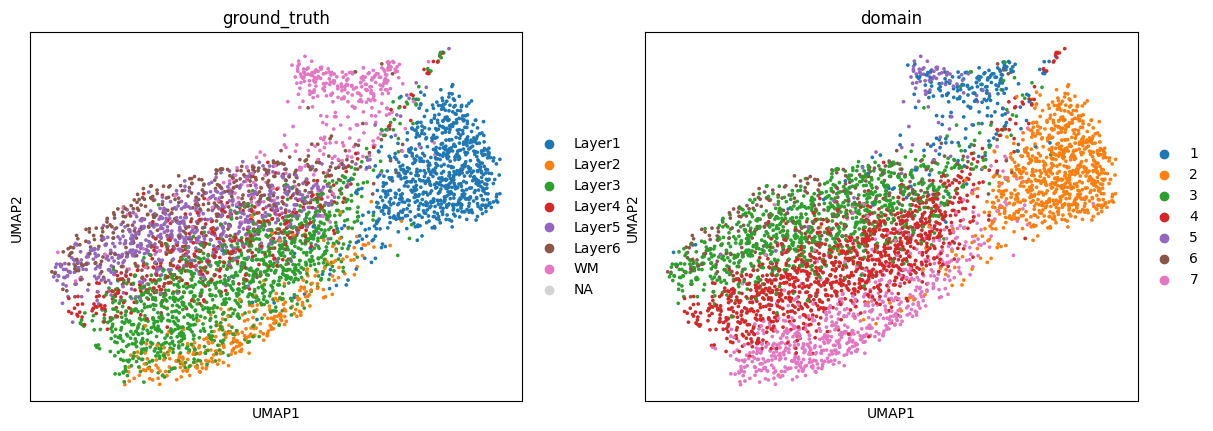

In [44]:
sc.pl.umap(
    adata1,
    color=['ground_truth', 'domain']
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

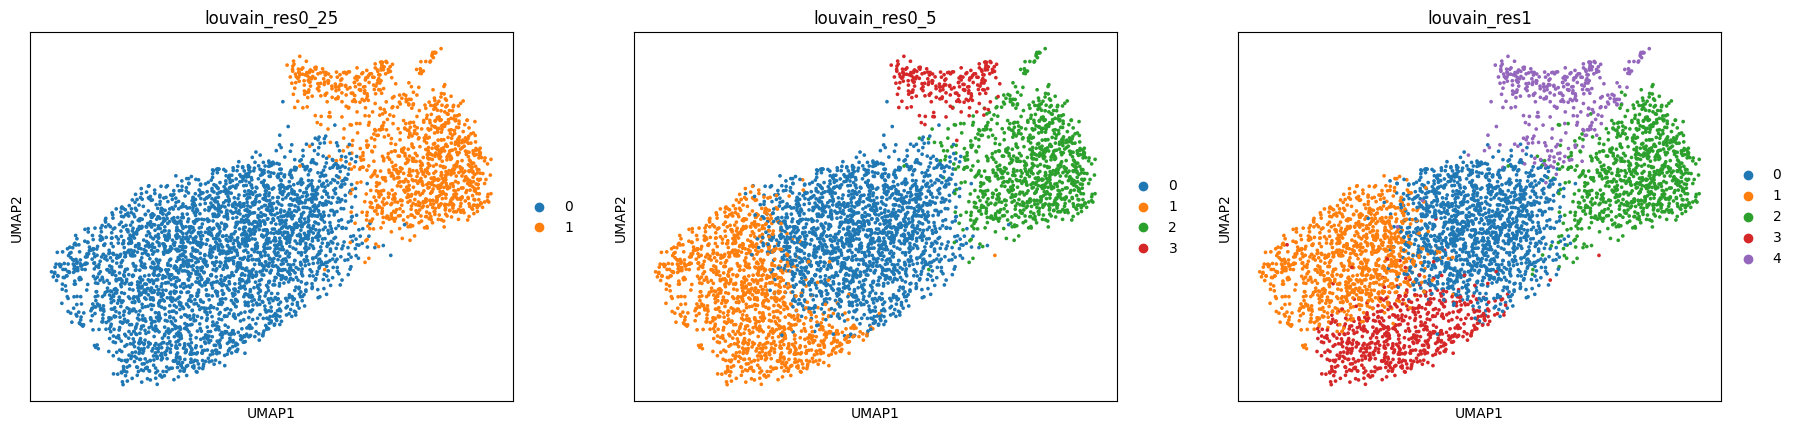

In [37]:
sc.pl.umap(
    adata1,
    color=['louvain_res0_25','louvain_res0_5', 'louvain_res1']
)

ARI:  0.567678836766058


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


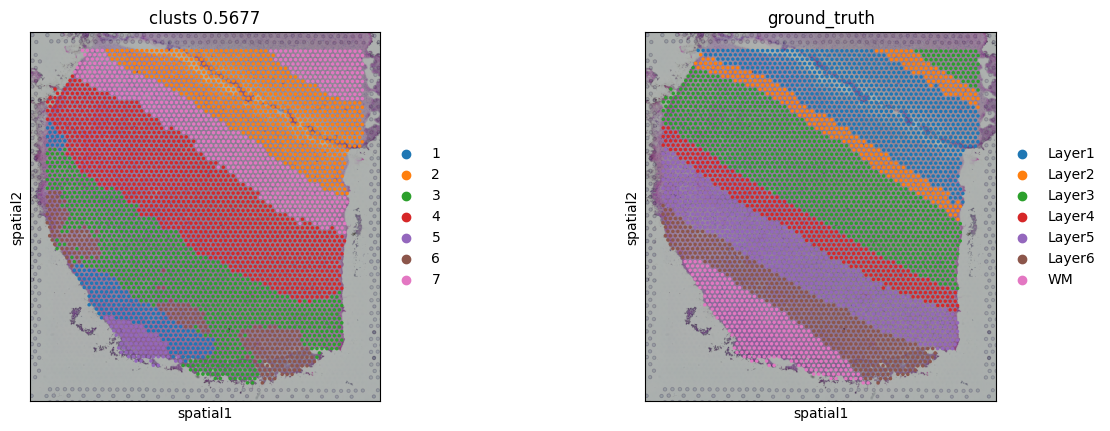

In [46]:
adata1 = adata1[~pd.isnull(adata1.obs['ground_truth'])]

ARI = metrics.adjusted_rand_score(adata1.obs['domain'], adata1.obs['ground_truth'])
spatdata.uns['ARI']=ARI

# print('Dataset:', dataset)
print('ARI: ', ARI)
sc.pl.spatial(adata1, img_key='hires',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
              save=None)      

In [48]:
adata1.obs

['8', '21', '6', '27', '29', ..., '14', '23', '22', '13', '32']
Length: 33
Categories (33, object): ['0', '1', '2', '3', ..., '29', '30', '31', '32']

In [ ]:
sc.pp.highly_variable_genes(adata1, n_top_genes=2000, flavor='seurat_v3', batch_key=batch_key)

In [20]:
df_151509

AAACAACGAATAGTTC-1  AAACAAGTATCTCCCA-1  AAACACCAATAACTGC-1  \
rownames                                                                      
ENSG00000243485                 0.0                 0.0                 0.0   
ENSG00000237613                 0.0                 0.0                 0.0   
ENSG00000186092                 0.0                 0.0                 0.0   
ENSG00000238009                 0.0                 0.0                 0.0   
ENSG00000239945                 0.0                 0.0                 0.0   
...                             ...                 ...                 ...   
ENSG00000277856                 0.0                 0.0                 0.0   
ENSG00000275063                 0.0                 0.0                 0.0   
ENSG00000271254                 0.0                 0.0                 0.0   
ENSG00000277475                 0.0                 0.0                 0.0   
ENSG00000268674                 0.0                 0.0                 0.0   

                 AAACAGAGCGACTCCT-1  AAACAGGGTCTATATT-1  AAACAGTGTTCCTGGG-1  \
rownames                                                                      
ENSG00000243485                 0.0                 0.0                 0.0   
ENSG00000237613                 0.0                 0.0                 0.0   
ENSG00000186092                 0.0                 0.0                 0.0   
ENSG00000238009                 0.0                 0.0                 0.0   
ENSG00000239945                 0.0                 0.0                 0.0   
...                             ...                 ...                 ...   
ENSG00000277856                 0.0                 0.0                 0.0   
ENSG00000275063                 0.0                 0.0                 0.0   
ENSG00000271254                 0.0                 0.0                 0.0   
ENSG00000277475                 0.0                 0.0                 0.0   
ENSG00000268674                 0.0                 0.0                 0.0   

                 AAACATTTCCCGGATT-1  AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  \
rownames                                                                      
ENSG00000243485                 0.0                 0.0                 0.0   
ENSG00000237613                 0.0                 0.0                 0.0   
ENSG00000186092                 0.0                 0.0                 0.0   
ENSG00000238009                 0.0                 0.0                 0.0   
ENSG00000239945                 0.0                 0.0                 0.0   
...                             ...                 ...                 ...   
ENSG00000277856                 0.0                 0.0                 0.0   
ENSG00000275063                 0.0                 0.0                 0.0   
ENSG00000271254                 0.0                 0.0                 0.0   
ENSG00000277475                 0.0                 0.0                 0.0   
ENSG00000268674                 0.0                 0.0                 0.0   

                 AAACCGTTCGTCCAGG-1  ...  TTGTGGTGGTACTAAG-1  \
rownames                             ...                       
ENSG00000243485                 0.0  ...                 0.0   
ENSG00000237613                 0.0  ...                 0.0   
ENSG00000186092                 0.0  ...                 0.0   
ENSG00000238009                 0.0  ...                 0.0   
ENSG00000239945                 0.0  ...                 0.0   
...                             ...  ...                 ...   
ENSG00000277856                 0.0  ...                 0.0   
ENSG00000275063                 0.0  ...                 0.0   
ENSG00000271254                 0.0  ...                 0.0   
ENSG00000277475                 0.0  ...                 0.0   
ENSG00000268674                 0.0  ...                 0.0   

                 TTGTGTATGCCACCAA-1  TTGTGTTTCCCGAAAG-1  TTGTTAGCAAATTCGA-1  \
rownames             

In [21]:
df_spat676

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485-spat            0.498831            0.500420   
ENSG00000237613-spat            0.498831            0.500420   
ENSG00000186092-spat            0.498831            0.500420   
ENSG00000238009-spat            0.498827            0.500417   
ENSG00000239945-spat            0.498831            0.500420   
...                                  ...                 ...   
ENSG00000277856-spat            0.498831            0.500420   
ENSG00000275063-spat            0.498831            0.500420   
ENSG00000271254-spat            0.498826            0.500416   
ENSG00000277475-spat            0.498831            0.500420   
ENSG00000268674-spat            0.498831            0.500420   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485-spat            0.500737            0.504955   
ENSG00000237613-spat            0.500737            0.504955   
ENSG00000186092-spat            0.500737            0.504955   
ENSG00000238009-spat            0.500731            0.504951   
ENSG00000239945-spat            0.500737            0.504955   
...                                  ...                 ...   
ENSG00000277856-spat            0.500737            0.504955   
ENSG00000275063-spat            0.500737            0.504955   
ENSG00000271254-spat            0.500731            0.504953   
ENSG00000277475-spat            0.500737            0.504955   
ENSG00000268674-spat            0.500737            0.504955   

                      AAACAGGGTCTATATT-1  AAACATTTCCCGGATT-1  \
ENSG00000243485-spat            0.500202            0.502837   
ENSG00000237613-spat            0.500202            0.502837   
ENSG00000186092-spat            0.500202            0.502837   
ENSG00000238009-spat            0.500198            0.502831   
ENSG00000239945-spat            0.500202            0.502837   
...                                  ...                 ...   
ENSG00000277856-spat            0.500202            0.502837   
ENSG00000275063-spat            0.500202            0.502837   
ENSG00000271254-spat            0.500198            0.502830   
ENSG00000277475-spat            0.500202            0.502837   
ENSG00000268674-spat            0.500202            0.502837   

                      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  \
ENSG00000243485-spat            0.504281            0.503841   
ENSG00000237613-spat            0.504281            0.503841   
ENSG00000186092-spat            0.504281            0.503841   
ENSG00000238009-spat            0.504282            0.503843   
ENSG00000239945-spat            0.504281            0.503841   
...                                  ...                 ...   
ENSG00000277856-spat            0.504281            0.503841   
ENSG00000275063-spat            0.504281            0.503841   
ENSG00000271254-spat            0.504285            0.503843   
ENSG00000277475-spat            0.504281            0.503841   
ENSG00000268674-spat            0.504281            0.503841   

                      AAACCGTTCGTCCAGG-1  AAACCTAAGCAGCCGG-1  ...  \
ENSG00000243485-spat            0.501828            0.501383  ...   
ENSG00000237613-spat            0.501828            0.501383  ...   
ENSG00000186092-spat            0.501828            0.501383  ...   
ENSG00000238009-spat            0.501827            0.501382  ...   
ENSG00000239945-spat            0.501828            0.501383  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.501828            0.501383  ...   
ENSG00000275063-spat            0.501828            0.501383  ...   
ENSG00000271254-spat            0.501823            0.501378  ...   
ENSG00000277475-spat            0.501828            0.501383  ...   
ENSG00000268674-spat            0.501828            0.501383  ...   

                      TTGTGGTGGTACTAAG-1  TTGTGTATGCCACCAA-1  \
ENSG00000243485-spat            0.503919            0

In [22]:
embed_507 = pd.concat([df_151507,df_spat507], axis=0)
embed_507

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.506234            0.502598   
ENSG00000275063-spat            0.506234            0.502598   
ENSG00000271254-spat            0.506235            0.502592   
ENSG00000277475-spat            0.506234            0.502598   
ENSG00000268674-spat            0.506233            0.502593   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503589            0.501395   
ENSG00000275063-spat            0.503589            0.501395   
ENSG00000271254-spat            0.503590            0.501394   
ENSG00000277475-spat            0.503589            0.501395   
ENSG00000268674-spat            0.503588            0.501393   

                      AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.501936            0.503632   
ENSG00000275063-spat            0.501936            0.503632   
ENSG00000271254-spat            0.501928            0.503636   
ENSG00000277475-spat            0.501936            0.503632   
ENSG00000268674-spat            0.501930            0.503636   

                      AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.505138            0.504154   
ENSG00000275063-spat            0.505138            0.504154   
ENSG00000271254-spat            0.505130            0.504144   
ENSG00000277475-spat            0.505138            0.504154   
ENSG00000268674-spat            0.505131            0.504148   

                      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.500667            0.499568  ...   
ENSG00000275063-spat            0.500667            0.499568  ...   
ENSG00000271254-spat            0.500661            0.499568  ...   
ENSG00000277475-spat            0.500667            0.499568  ...   
ENSG00000268674-spat            0.500664            0.499568  ...   

                      TTGTGTATGCCACCAA-1  TTGTGTTTCCCGAAAG-1  \
ENSG00000243485                 0.000000            0

In [23]:
embed_508 = pd.concat([df_151508,df_spat508], axis=0)
embed_508

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503769            0.500502   
ENSG00000275063-spat            0.503769            0.500502   
ENSG00000271254-spat            0.503765            0.500503   
ENSG00000277475-spat            0.503769            0.500502   
ENSG00000268674-spat            0.503769            0.500502   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.505402            0.503190   
ENSG00000275063-spat            0.505402            0.503190   
ENSG00000271254-spat            0.505390            0.503166   
ENSG00000277475-spat            0.505402            0.503190   
ENSG00000268674-spat            0.505402            0.503190   

                      AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.502415            0.504652   
ENSG00000275063-spat            0.502415            0.504652   
ENSG00000271254-spat            0.502422            0.504656   
ENSG00000277475-spat            0.502415            0.504652   
ENSG00000268674-spat            0.502415            0.504652   

                      AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.501619            0.500012   
ENSG00000275063-spat            0.501619            0.500012   
ENSG00000271254-spat            0.501611            0.500001   
ENSG00000277475-spat            0.501619            0.500012   
ENSG00000268674-spat            0.501619            0.500012   

                      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.499204            0.504720  ...   
ENSG00000275063-spat            0.499204            0.504720  ...   
ENSG00000271254-spat            0.499202            0.504706  ...   
ENSG00000277475-spat            0.499204            0.504720  ...   
ENSG00000268674-spat            0.499204            0.504720  ...   

                      TTGTGTATGCCACCAA-1  TTGTGTTTCCCGAAAG-1  \
ENSG00000243485                 0.000000            0

In [24]:
embed_509 = pd.concat([df_151509,df_spat509], axis=0)
embed_509

AAACAACGAATAGTTC-1  AAACAAGTATCTCCCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.504765            0.499230   
ENSG00000275063-spat            0.504765            0.499230   
ENSG00000271254-spat            0.504754            0.499215   
ENSG00000277475-spat            0.504765            0.499230   
ENSG00000268674-spat            0.504765            0.499230   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.510723            0.501286   
ENSG00000275063-spat            0.510723            0.501286   
ENSG00000271254-spat            0.510695            0.501274   
ENSG00000277475-spat            0.510723            0.501286   
ENSG00000268674-spat            0.510723            0.501286   

                      AAACAGGGTCTATATT-1  AAACAGTGTTCCTGGG-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503894            0.496925   
ENSG00000275063-spat            0.503894            0.496925   
ENSG00000271254-spat            0.503886            0.496928   
ENSG00000277475-spat            0.503894            0.496925   
ENSG00000268674-spat            0.503894            0.496925   

                      AAACATTTCCCGGATT-1  AAACCCGAACGAAATC-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.504449            0.505275   
ENSG00000275063-spat            0.504449            0.505275   
ENSG00000271254-spat            0.504436            0.505271   
ENSG00000277475-spat            0.504449            0.505275   
ENSG00000268674-spat            0.504449            0.505275   

                      AAACCGGGTAGGTACC-1  AAACCGTTCGTCCAGG-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.503467            0.501557  ...   
ENSG00000275063-spat            0.503467            0.501557  ...   
ENSG00000271254-spat            0.503443            0.501542  ...   
ENSG00000277475-spat            0.503467            0.501557  ...   
ENSG00000268674-spat            0.503467            0.501557  ...   

                      TTGTGGTGGTACTAAG-1  TTGTGTATGCCACCAA-1  \
ENSG00000243485                 0.000000            0

In [25]:
embed_676 = pd.concat([df_151676,df_spat676], axis=0)
embed_676

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.498831            0.500420   
ENSG00000275063-spat            0.498831            0.500420   
ENSG00000271254-spat            0.498826            0.500416   
ENSG00000277475-spat            0.498831            0.500420   
ENSG00000268674-spat            0.498831            0.500420   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.500737            0.504955   
ENSG00000275063-spat            0.500737            0.504955   
ENSG00000271254-spat            0.500731            0.504953   
ENSG00000277475-spat            0.500737            0.504955   
ENSG00000268674-spat            0.500737            0.504955   

                      AAACAGGGTCTATATT-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.500202            0.502837   
ENSG00000275063-spat            0.500202            0.502837   
ENSG00000271254-spat            0.500198            0.502830   
ENSG00000277475-spat            0.500202            0.502837   
ENSG00000268674-spat            0.500202            0.502837   

                      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.504281            0.503841   
ENSG00000275063-spat            0.504281            0.503841   
ENSG00000271254-spat            0.504285            0.503843   
ENSG00000277475-spat            0.504281            0.503841   
ENSG00000268674-spat            0.504281            0.503841   

                      AAACCGTTCGTCCAGG-1  AAACCTAAGCAGCCGG-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.501828            0.501383  ...   
ENSG00000275063-spat            0.501828            0.501383  ...   
ENSG00000271254-spat            0.501823            0.501378  ...   
ENSG00000277475-spat            0.501828            0.501383  ...   
ENSG00000268674-spat            0.501828            0.501383  ...   

                      TTGTGGTGGTACTAAG-1  TTGTGTATGCCACCAA-1  \
ENSG00000243485                 0.000000            0

In [26]:
embed_507_508 = pd.concat([embed_507,embed_508],axis=1)
embed_507_508

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.506234            0.502598   
ENSG00000275063-spat            0.506234            0.502598   
ENSG00000271254-spat            0.506235            0.502592   
ENSG00000277475-spat            0.506234            0.502598   
ENSG00000268674-spat            0.506233            0.502593   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503589            0.501395   
ENSG00000275063-spat            0.503589            0.501395   
ENSG00000271254-spat            0.503590            0.501394   
ENSG00000277475-spat            0.503589            0.501395   
ENSG00000268674-spat            0.503588            0.501393   

                      AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.501936            0.503632   
ENSG00000275063-spat            0.501936            0.503632   
ENSG00000271254-spat            0.501928            0.503636   
ENSG00000277475-spat            0.501936            0.503632   
ENSG00000268674-spat            0.501930            0.503636   

                      AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.505138            0.504154   
ENSG00000275063-spat            0.505138            0.504154   
ENSG00000271254-spat            0.505130            0.504144   
ENSG00000277475-spat            0.505138            0.504154   
ENSG00000268674-spat            0.505131            0.504148   

                      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.500667            0.499568  ...   
ENSG00000275063-spat            0.500667            0.499568  ...   
ENSG00000271254-spat            0.500661            0.499568  ...   
ENSG00000277475-spat            0.500667            0.499568  ...   
ENSG00000268674-spat            0.500664            0.499568  ...   

                      TTGTGTATGCCACCAA-1  TTGTGTTTCCCGAAAG-1  \
ENSG00000243485                 0.000000            0

In [27]:
embed_507_508_509 = pd.concat([embed_507_508,embed_509],axis=1)
embed_507_508_509

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.506234            0.502598   
ENSG00000275063-spat            0.506234            0.502598   
ENSG00000271254-spat            0.506235            0.502592   
ENSG00000277475-spat            0.506234            0.502598   
ENSG00000268674-spat            0.506233            0.502593   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503589            0.501395   
ENSG00000275063-spat            0.503589            0.501395   
ENSG00000271254-spat            0.503590            0.501394   
ENSG00000277475-spat            0.503589            0.501395   
ENSG00000268674-spat            0.503588            0.501393   

                      AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.501936            0.503632   
ENSG00000275063-spat            0.501936            0.503632   
ENSG00000271254-spat            0.501928            0.503636   
ENSG00000277475-spat            0.501936            0.503632   
ENSG00000268674-spat            0.501930            0.503636   

                      AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.505138            0.504154   
ENSG00000275063-spat            0.505138            0.504154   
ENSG00000271254-spat            0.505130            0.504144   
ENSG00000277475-spat            0.505138            0.504154   
ENSG00000268674-spat            0.505131            0.504148   

                      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.500667            0.499568  ...   
ENSG00000275063-spat            0.500667            0.499568  ...   
ENSG00000271254-spat            0.500661            0.499568  ...   
ENSG00000277475-spat            0.500667            0.499568  ...   
ENSG00000268674-spat            0.500664            0.499568  ...   

                      TTGTGGTGGTACTAAG-1  TTGTGTATGCCACCAA-1  \
ENSG00000243485                 0.000000            0

In [28]:
embed_all = pd.concat([embed_507_508_509,embed_676],axis=1)
embed_all

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.506234            0.502598   
ENSG00000275063-spat            0.506234            0.502598   
ENSG00000271254-spat            0.506235            0.502592   
ENSG00000277475-spat            0.506234            0.502598   
ENSG00000268674-spat            0.506233            0.502593   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503589            0.501395   
ENSG00000275063-spat            0.503589            0.501395   
ENSG00000271254-spat            0.503590            0.501394   
ENSG00000277475-spat            0.503589            0.501395   
ENSG00000268674-spat            0.503588            0.501393   

                      AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.501936            0.503632   
ENSG00000275063-spat            0.501936            0.503632   
ENSG00000271254-spat            0.501928            0.503636   
ENSG00000277475-spat            0.501936            0.503632   
ENSG00000268674-spat            0.501930            0.503636   

                      AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.505138            0.504154   
ENSG00000275063-spat            0.505138            0.504154   
ENSG00000271254-spat            0.505130            0.504144   
ENSG00000277475-spat            0.505138            0.504154   
ENSG00000268674-spat            0.505131            0.504148   

                      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.500667            0.499568  ...   
ENSG00000275063-spat            0.500667            0.499568  ...   
ENSG00000271254-spat            0.500661            0.499568  ...   
ENSG00000277475-spat            0.500667            0.499568  ...   
ENSG00000268674-spat            0.500664            0.499568  ...   

                      TTGTGGTGGTACTAAG-1  TTGTGTATGCCACCAA-1  \
ENSG00000243485                 0.000000            0

In [29]:
embed_all.fillna(0,inplace=True)
embed_all

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.506234            0.502598   
ENSG00000275063-spat            0.506234            0.502598   
ENSG00000271254-spat            0.506235            0.502592   
ENSG00000277475-spat            0.506234            0.502598   
ENSG00000268674-spat            0.506233            0.502593   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503589            0.501395   
ENSG00000275063-spat            0.503589            0.501395   
ENSG00000271254-spat            0.503590            0.501394   
ENSG00000277475-spat            0.503589            0.501395   
ENSG00000268674-spat            0.503588            0.501393   

                      AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.501936            0.503632   
ENSG00000275063-spat            0.501936            0.503632   
ENSG00000271254-spat            0.501928            0.503636   
ENSG00000277475-spat            0.501936            0.503632   
ENSG00000268674-spat            0.501930            0.503636   

                      AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.505138            0.504154   
ENSG00000275063-spat            0.505138            0.504154   
ENSG00000271254-spat            0.505130            0.504144   
ENSG00000277475-spat            0.505138            0.504154   
ENSG00000268674-spat            0.505131            0.504148   

                      AAACCCGAACGAAATC-1  AAACCGGGTAGGTACC-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.500667            0.499568  ...   
ENSG00000275063-spat            0.500667            0.499568  ...   
ENSG00000271254-spat            0.500661            0.499568  ...   
ENSG00000277475-spat            0.500667            0.499568  ...   
ENSG00000268674-spat            0.500664            0.499568  ...   

                      TTGTGGTGGTACTAAG-1  TTGTGTATGCCACCAA-1  \
ENSG00000243485                 0.000000            0

In [30]:
# embed_507_509 = pd.concat([embed_507,embed_509],axis=1)
# embed_all = pd.concat([embed_507_509,embed_676],axis=1)
# embed_all

In [31]:
row_names = embed_all.index
row_names_df = row_names.to_frame(index=False)
row_names_df.to_csv('processed_data/5th_index_name_com3all.csv')
row_names_df

0
0           ENSG00000243485
1           ENSG00000237613
2           ENSG00000186092
3           ENSG00000238009
4           ENSG00000239945
...                     ...
67071  ENSG00000277856-spat
67072  ENSG00000275063-spat
67073  ENSG00000271254-spat
67074  ENSG00000277475-spat
67075  ENSG00000268674-spat

[67076 rows x 1 columns]

In [32]:
# embed_all.to_csv('dataset/datapoints/embed_all.csv',index = False)

# Save DataFrame to CSV with progress bar
chunks = np.array_split(embed_all.index, 1000) # split into 1000 chunks

for chunck, subset in enumerate(tqdm(chunks)):
    if chunck == 0: # first row
        embed_all.loc[subset].to_csv('processed_data/5thset_embed_all_com3all.csv', mode='w', index=True)
    else:
        embed_all.loc[subset].to_csv('processed_data/5thset_embed_all_com3all.csv', header=None, mode='a', index=True)
# embed_all.to_csv('dataset/datapoints/embed_all_com3.csv',index = True, chunksize=1000)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:56<00:00,  1.86it/s]


In [34]:
import sys
a = sys.getsizeof(df_spat507)/(1024 ** 2)
b = sys.getsizeof(df_151507)/(1024 ** 2)
c = sys.getsizeof(df_spat509)/(1024 ** 2)
d = sys.getsizeof(df_151509)/(1024 ** 2)
e = sys.getsizeof(df_spat676)/(1024 ** 2)
f = sys.getsizeof(df_151676)/(1024 ** 2)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)

print('total: ',a+b+c+d+e+f)
print(sys.getsizeof(embed_all)/(1024 ** 2))

1083.789011001587
1083.6290893554688
1029.7994632720947
1029.6395416259766
933.5906009674072
933.4306793212891
total:  6093.878385543823
6086.362642288208


In [51]:
import sys
a = sys.getsizeof(df_spat507)/(1024 ** 2)
b = sys.getsizeof(df_151507)/(1024 ** 2)
c = sys.getsizeof(df_spat509)/(1024 ** 2)
d = sys.getsizeof(df_151509)/(1024 ** 2)
e = sys.getsizeof(df_spat676)/(1024 ** 2)
f = sys.getsizeof(df_151676)/(1024 ** 2)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)

print(a+b+c+d+e+f)
print(sys.getsizeof(embed_all)/(1024 ** 2))

552.9777374267578
1083.6290893554688
637.4516143798828
1029.6395416259766
734.5240631103516
933.4306793212891
4971.652725219727
4967.775676727295


In [26]:
import sys
a = sys.getsizeof(df_spat507)/(1024 ** 2)
b = sys.getsizeof(df_151507)/(1024 ** 2)
c = sys.getsizeof(df_spat509)/(1024 ** 2)
d = sys.getsizeof(df_151509)/(1024 ** 2)
e = sys.getsizeof(df_spat676)/(1024 ** 2)
f = sys.getsizeof(df_151676)/(1024 ** 2)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)

print(a+b+c+d+e+f)
print(sys.getsizeof(embed_all)/(1024 ** 2))

1083.789011001587
1083.6290893554688
1029.7994632720947
1029.6395416259766
933.5906009674072
933.4306793212891
6093.878385543823
6086.362642288208


In [26]:
# embed_507.to_csv('processed_data/embed_507.csv', index=True)
embed_509.to_csv('processed_data/embed_509.csv', index=True)
embed_676.to_csv('processed_data/embed_676.csv', index=True)

In [33]:
embed_507.to_feather('processed_data/5thset_embed_507.feather')
embed_508.to_feather('processed_data/5thset_embed_508.feather')
embed_509.to_feather('processed_data/5thset_embed_509.feather')
embed_676.to_feather('processed_data/5thset_embed_676.feather')

In [39]:
# embed_507.to_csv('datapoints/embedded_507.csv', index=False)
pyreadr.write_rds('processed_data/embedall_507.rds', embed_507, compress='gzip')

In [ ]:
pyreadr.write_rds('processed_data/embedall_509.rds', embed_509, compress='gzip')

In [ ]:
pyreadr.write_rds('processed_data/embedall_676.rds', embed_676, compress='gzip')

In [36]:
embed_507.to_hdf('processed_data/embedall_507.h5', key='emb507', mode='w')

In [37]:
embed_509.to_hdf('processed_data/embedall_509.h5', key='emb509', mode='w')

In [38]:
embed_676.to_hdf('processed_data/embedall_676.h5', key='emb676', mode='w')

In [32]:
os.getcwd()

'/workspace/volume/spatial_integration/GNN_based/combined'

In [27]:
trial_507 = pd.read_csv('processed_data/embed_507.csv')
feather_507 = pd.read_feather('processed_data/embed_507.feather')

In [45]:
trial_507.iloc[:,1:].equals(feather_507)

False

In [28]:
new_507 = trial_507.iloc[:,1:]
new_507.index = feather_507.index
new_507

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.501913            0.503550   
ENSG00000275063-spat            0.501913            0.503550   
ENSG00000271254-spat            0.501901            0.503529   
ENSG00000277475-spat            0.501913            0.503550   
ENSG00000268674-spat            0.501913            0.503550   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503174            0.498783   
ENSG00000275063-spat            0.503174            0.498783   
ENSG00000271254-spat            0.503163            0.498781   
ENSG00000277475-spat            0.503174            0.498783   
ENSG00000268674-spat            0.503174            0.498783   

                      AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503245            0.500837   
ENSG00000275063-spat            0.503245            0.500837   
ENSG00000271254-spat            0.503233            0.500830   
ENSG00000277475-spat            0.503245            0.500837   
ENSG00000268674-spat            0.503245            0.500837   

                      AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.500174            0.504906   
ENSG00000275063-spat            0.500174            0.504906   
ENSG00000271254-spat            0.500170            0.504898   
ENSG00000277475-spat            0.500174            0.504906   
ENSG00000268674-spat            0.500174            0.504906   

                      AAACCACTACACAGAT-1  AAACCCGAACGAAATC-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.505264            0.501175  ...   
ENSG00000275063-spat            0.505264            0.501175  ...   
ENSG00000271254-spat            0.505260            0.501167  ...   
ENSG00000277475-spat            0.505264            0.501175  ...   
ENSG00000268674-spat            0.505264            0.501175  ...   

                      TTGTGTTTCCCGAAAG-1  TTGTTAGCAAATTCGA-1  \
ENSG00000243485                 0.000000            0

In [36]:
feather_507

AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.501913            0.503550   
ENSG00000275063-spat            0.501913            0.503550   
ENSG00000271254-spat            0.501901            0.503529   
ENSG00000277475-spat            0.501913            0.503550   
ENSG00000268674-spat            0.501913            0.503550   

                      AAACACCAATAACTGC-1  AAACAGAGCGACTCCT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503174            0.498783   
ENSG00000275063-spat            0.503174            0.498783   
ENSG00000271254-spat            0.503163            0.498781   
ENSG00000277475-spat            0.503174            0.498783   
ENSG00000268674-spat            0.503174            0.498783   

                      AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.503245            0.500837   
ENSG00000275063-spat            0.503245            0.500837   
ENSG00000271254-spat            0.503233            0.500830   
ENSG00000277475-spat            0.503245            0.500837   
ENSG00000268674-spat            0.503245            0.500837   

                      AAACAGTGTTCCTGGG-1  AAACATTTCCCGGATT-1  \
ENSG00000243485                 0.000000            0.000000   
ENSG00000237613                 0.000000            0.000000   
ENSG00000186092                 0.000000            0.000000   
ENSG00000238009                 0.000000            0.000000   
ENSG00000239945                 0.000000            0.000000   
...                                  ...                 ...   
ENSG00000277856-spat            0.500174            0.504906   
ENSG00000275063-spat            0.500174            0.504906   
ENSG00000271254-spat            0.500170            0.504898   
ENSG00000277475-spat            0.500174            0.504906   
ENSG00000268674-spat            0.500174            0.504906   

                      AAACCACTACACAGAT-1  AAACCCGAACGAAATC-1  ...  \
ENSG00000243485                 0.000000            0.000000  ...   
ENSG00000237613                 0.000000            0.000000  ...   
ENSG00000186092                 0.000000            0.000000  ...   
ENSG00000238009                 0.000000            0.000000  ...   
ENSG00000239945                 0.000000            0.000000  ...   
...                                  ...                 ...  ...   
ENSG00000277856-spat            0.505264            0.501175  ...   
ENSG00000275063-spat            0.505264            0.501175  ...   
ENSG00000271254-spat            0.505260            0.501167  ...   
ENSG00000277475-spat            0.505264            0.501175  ...   
ENSG00000268674-spat            0.505264            0.501175  ...   

                      TTGTGTTTCCCGAAAG-1  TTGTTAGCAAATTCGA-1  \
ENSG00000243485                 0.000000            0

In [29]:
values_equal = new_507.values == feather_507.values
all_equal = values_equal.all()
all_equal

False

In [30]:
row_indices, col_indices = values_equal.nonzero()
diff_locations = [(row, col) for row, col in zip(row_indices, col_indices) if not values_equal[row, col]]

print("Values differ at the following locations:")
for (row, col) in diff_locations:
    print(f"Row {row}, Column {col}")

Values differ at the following locations:


In [37]:
np.sum(values_equal==False)

10454527

In [38]:
np.sum(values_equal==True)

283606657

In [41]:
tolerance = 0.000001
approx_equal = np.allclose(new_507, feather_507,atol=tolerance)
approx_equal

True